In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# /kaggle/input/song-popularity/dataset.csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Описание признаков

1. **Unnamed: 0** — столбец, дублирующий индекс

2. **track_id** — уникальный идентификатор трека. Используется для идентификации песни в базе данных.

3. **artists** — имя исполнителя или группы, записавшей трек.

4. **album_name** — название альбома, в который входит трек.

5. **track_name** — название трека.

6. **popularity** — показатель популярности трека, где большее значение означает более популярный трек. Значения в диапазоне от 0 до 100.

7. **duration_ms** — длительность трека в миллисекундах.

8. **explicit** — флаг, указывающий на наличие ненормативной лексики. Значение `True` означает, что трек содержит контент для взрослых, `False` — что не содержит.

9. **danceability** — коэффициент танцевальности. Это числовой показатель от 0 до 1, отражающий, насколько трек подходит для танцев.

10. **energy** — показатель «энергии» трека. Значение от 0 до 1, где высокий уровень энергии означает быстрый и громкий трек.

11. **key** — тональность трека, представлена в числовом виде.

12. **loudness** — средняя громкость трека в децибелах (dB), где более высокое значение соответствует более громкому треку.

13. **mode** — режим тональности, где `1` — мажор, `0` — минор.

14. **speechiness** — показатель речевого контента. Значение от 0 до 1, где более высокие значения означают большую долю слов в треке.

15. **acousticness** — показатель акустичности, от 0 до 1. Чем ближе к 1, тем выше вероятность, что трек является акустическим.

16. **instrumentalness** — показатель инструментальности, от 0 до 1, где значения ближе к 1 указывают на отсутствие вокала. Небольшие значения могут означать вокал или речь.

17. **liveness** — показатель «живости» трека, от 0 до 1. Более высокие значения указывают на присутствие аудитории и элементы живого исполнения.

18. **valence** — показатель настроения трека, от 0 до 1. Высокие значения означают «позитивное» звучание, тогда как низкие значения связаны с меланхоличным или негативным настроением.

19. **tempo** — темп трека.

20. **time_signature** — размер трека, который представляет количество долей в одном такте.

21. **track_genre** — жанр трека, такой как "acoustic", "pop", "rock", и т.д.


# Загрузка датасета

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import tensorflow as tf
%matplotlib inline

Проверяю на чём обучается модель: CPU или GPU

In [4]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Модель обучается на GPU: {device_name}")
else:
    print("Модель обучается на CPU")

Модель обучается на CPU


In [5]:
BASE_URL = '/content/drive/MyDrive/Программирование нейронных сетей/songs_spotify/'

In [6]:
data = pd.read_csv(f'{BASE_URL}dataset_spotify_init.csv')

In [7]:
data_initial = data.copy(deep=True)

In [8]:
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [9]:
data.shape

(114000, 21)

In [10]:
data_initial.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [11]:
data.shape

(114000, 21)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

# Обработка DataFrame

In [13]:
data['popularity'].value_counts()

,count
popularity,
0,16020
22,2354
21,2344
44,2288
1,2140
...,...
96,7
94,7
95,5


50 - 94

In [14]:
data['popularity'].unique()

array([ 73,  55,  57,  71,  82,  58,  74,  80,  56,  69,  52,  62,  54,
        68,  67,  75,  63,  70,   0,   1,  46,  61,  60,  51,  66,  64,
        65,  44,  45,  50,  59,  49,  53,  47,  43,  42,  20,  22,  35,
        19,  24,  18,  23,  40,  38,  41,  30,  37,  39,  48,  36,  34,
        26,  32,  33,  21,  31,  28,  29,  27,  25,  16,   3,  12,   7,
        10,   9,  11,  17,   8,  15,  87,  83,  86,  93,  76,  78,   4,
         2,   5,  85,  81,  84,  72,  79,  77,   6,  13,  14,  89,  96,
       100,  98,  88,  92,  90,  91,  99,  97,  95,  94])

In [15]:
data.isnull().sum()

,0
Unnamed: 0,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


In [16]:
data = data.dropna()

In [17]:
data.isnull().sum()

,0
Unnamed: 0,0
track_id,0
artists,0
album_name,0
track_name,0
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


In [18]:
data.shape

(113999, 21)

In [19]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

In [20]:
numerical_features

['Unnamed: 0',
 'popularity',
 'duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [21]:
categorical_features

['track_id', 'artists', 'album_name', 'track_name', 'track_genre']

In [22]:
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

In [23]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        113999 non-null  int64  
 1   track_id          113999 non-null  int64  
 2   artists           113999 non-null  int64  
 3   album_name        113999 non-null  int64  
 4   track_name        113999 non-null  int64  
 5   popularity        113999 non-null  int64  
 6   duration_ms       113999 non-null  int64  
 7   explicit          113999 non-null  bool   
 8   danceability      113999 non-null  float64
 9   energy            113999 non-null  float64
 10  key               113999 non-null  int64  
 11  loudness          113999 non-null  float64
 12  mode              113999 non-null  int64  
 13  speechiness       113999 non-null  float64
 14  acousticness      113999 non-null  float64
 15  instrumentalness  113999 non-null  float64
 16  liveness          113999 

In [25]:
data.isnull().sum()

,0
Unnamed: 0,0
track_id,0
artists,0
album_name,0
track_name,0
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


# Аналитика

In [26]:
import numpy as np

In [27]:
sns.set(style="whitegrid")

## Распределение популярности треков

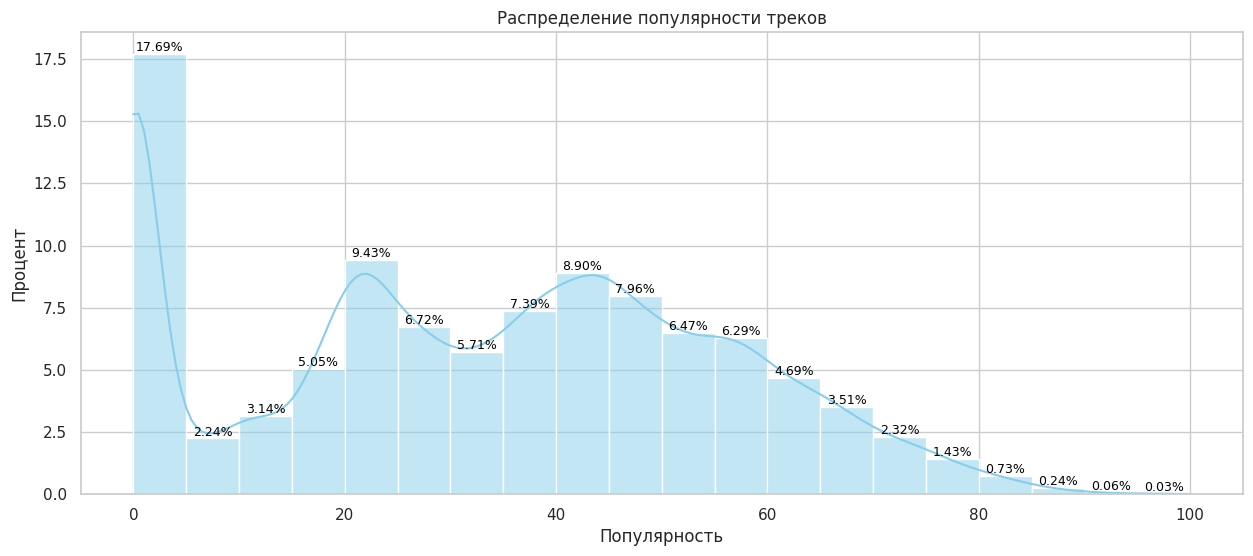

In [28]:
plt.figure(figsize=(15, 6))
histplot = sns.histplot(data['popularity'], bins=20, kde=True, color='skyblue', stat='percent')
plt.title('Распределение популярности треков')
plt.xlabel('Популярность')
plt.ylabel('Процент')

for p in histplot.patches:
    height = p.get_height()
    # Добавляем подпись, только если высота больше 0
    if height > 0:
        plt.text(p.get_x() + p.get_width() / 2, height, f'{height:.2f}%',
                 ha='center', va='bottom', fontsize=9, color='black')

plt.show()

Видно, что подавляющее большинство треков с популярностью равной 0. Также много треков с популярностью от 20 до 60. С популярностью выше 80 всего около 1% треков

## Процентное соотношение треков с ненормативной лексикой и без

In [29]:
explicit_counts = data['explicit'].value_counts()
explicit_counts

,count
explicit,
False,104252
True,9747


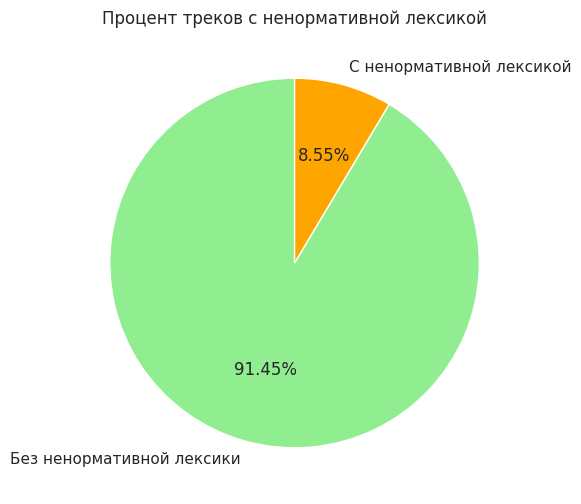

In [30]:
plt.figure(figsize=(6, 6))
plt.pie(explicit_counts, labels=['Без ненормативной лексики', 'С ненормативной лексикой'],
        autopct='%.2f%%', startangle=90, colors=['lightgreen', 'orange'])
plt.title('Процент треков с ненормативной лексикой')
plt.show()


Видно, что треков без ненормативной лексики более чем в 10 раз больше, чем с ненормативной лексикой

## Влияние наличия ненормативной лексики в треке на его среднюю популярность

In [31]:
explicit_popularity = data_initial.groupby('explicit')['popularity'].mean().reset_index()

<ipython-input-32-d764ef992629>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=explicit_popularity, x='explicit', y='popularity', palette='viridis')


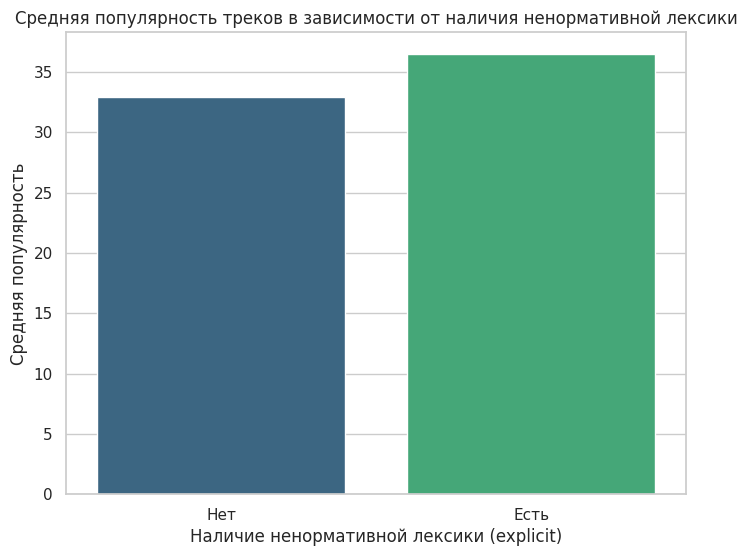

In [32]:
plt.figure(figsize=(8, 6))
sns.barplot(data=explicit_popularity, x='explicit', y='popularity', palette='viridis')

plt.title('Средняя популярность треков в зависимости от наличия ненормативной лексики')
plt.xlabel('Наличие ненормативной лексики (explicit)')
plt.ylabel('Средняя популярность')
plt.xticks([0, 1], labels=['Нет', 'Есть'])
plt.show()

На диаграмме показана средняя популярность треков с и без ненормативной лексики. Однако важно учитывать, что количество треков без ненормативной лексики значительно превышает количество треков с её наличием, более чем в 10 раз. Это может влиять на точность результатов. Несмотря на это, видно, что треки с ненормативной лексикой имеют более высокую среднюю популярность по сравнению с треками без неё

## Распределение треков по длительности в минутах

In [33]:
duration_min = data['duration_ms'] / 60000
max_duration = duration_min.max()
bins = [0, 1, 2, 3, 4, 5, 10, max_duration]

print(duration_min.head())
print('Maximum duration:', max_duration)

0    3.844433
1    2.493500
2    3.513767
3    3.365550
4    3.314217
Name: duration_ms, dtype: float64
Maximum duration: 87.28825


In [34]:
duration_counts = duration_min.value_counts(bins=bins, sort=False)
duration_counts

,count
"(-0.001, 1.0]",872
"(1.0, 2.0]",5427
"(2.0, 3.0]",26136
"(3.0, 4.0]",42384
"(4.0, 5.0]",22832
"(5.0, 10.0]",15745
"(10.0, 87.288]",603


In [35]:
labels = ['<1 мин', '1-2 мин', '2-3 мин', '3-4 мин', '4-5 мин', '5-10 мин', '10+ мин']

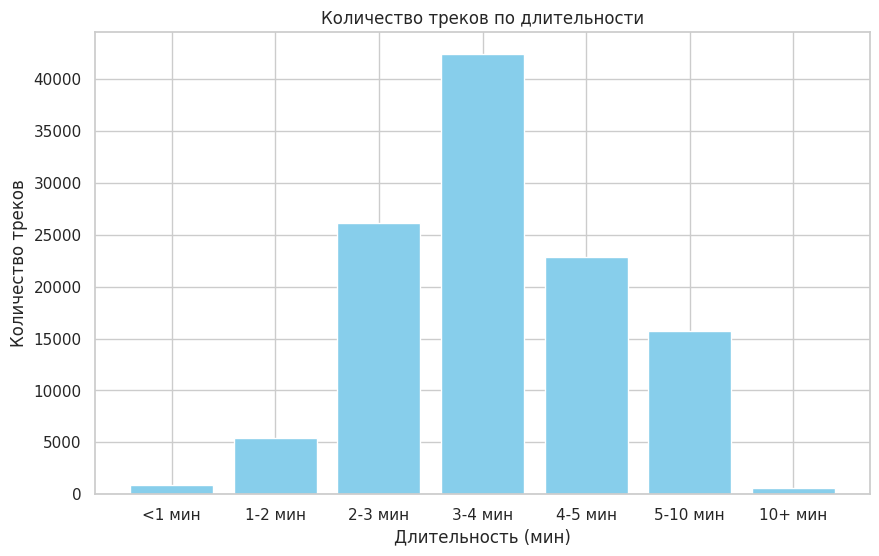

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(x=labels, height=duration_counts.values, color='skyblue')
plt.title('Количество треков по длительности')
plt.xlabel('Длительность (мин)')
plt.ylabel('Количество треков')
plt.show()

Видно, что больше всего треков длительностью 3-4 минуты. Также достаточно много треков длительностью 2-3 минуты и 4-10 минут

## Влияние длительности на популярность трека

In [37]:
duration_min = data_initial['duration_ms'] / 60000
bins = [0, 1, 2, 3, 4, 5, 10, duration_min.max()]
labels = ['<1 мин', '1-2 мин', '2-3 мин', '3-4 мин', '4-5 мин', '5-10 мин', '10+ мин']

data_initial['duration_category'] = pd.cut(duration_min, bins=bins, labels=labels)

duration_popularity = data_initial.groupby('duration_category')['popularity'].mean().reset_index()

<ipython-input-37-cb932e5c02b8>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_popularity = data_initial.groupby('duration_category')['popularity'].mean().reset_index()


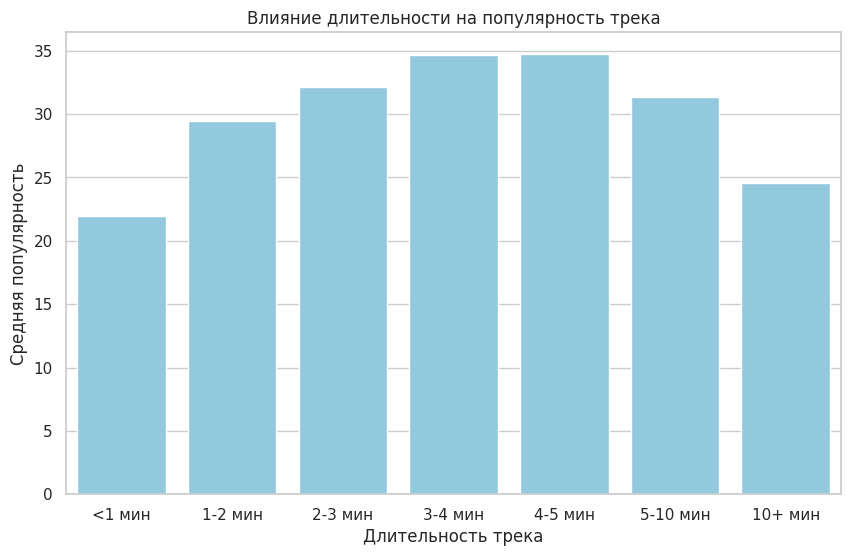

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(data=duration_popularity, x='duration_category', y='popularity', color='skyblue')

plt.title('Влияние длительности на популярность трека')
plt.xlabel('Длительность трека')
plt.ylabel('Средняя популярность')
plt.show()

Наибольшая средняя популярность у треков с длительностью от 3 до 5 минут. Следом идут треки с длительностью 2-3 минуты и треки длиной 5-10 минут. Худшая популярность у самых коротких треков

##  Распределение треков по жанрам

In [39]:
genre_counts = data_initial['track_genre'].value_counts()
genre_counts

,count
track_genre,
acoustic,1000
punk-rock,1000
progressive-house,1000
power-pop,1000
pop,1000
...,...
folk,1000
emo,1000
electronic,1000


Сделаю предположение, что на каждый жанр приходится по 1000 треков

In [40]:
maximum_tracks_by_genre = genre_counts.max()
minimum_tracks_by_genre = genre_counts.min()

print(f'Максимум треков по жанрам: {maximum_tracks_by_genre}')
print(f'Минимум треков по жанрам: {minimum_tracks_by_genre}')

Максимум треков по жанрам: 1000
Минимум треков по жанрам: 1000


Предположение подтвердилось. На каждый жанр приходится по 1000 треков

## Влияние жанра на популярность

In [41]:
genre_popularity = data_initial.groupby('track_genre')['popularity'].mean().reset_index()

# Сортируем по средней популярности (от популярного к непопулярному)
genre_popularity = genre_popularity.sort_values(by='popularity', ascending=False)

top_genres = genre_popularity.head(3)
bottom_genres = genre_popularity.tail(3)

selected_genres = pd.concat([top_genres, bottom_genres])

<ipython-input-42-780cf1d450f3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=selected_genres, x='track_genre', y='popularity', palette='viridis')


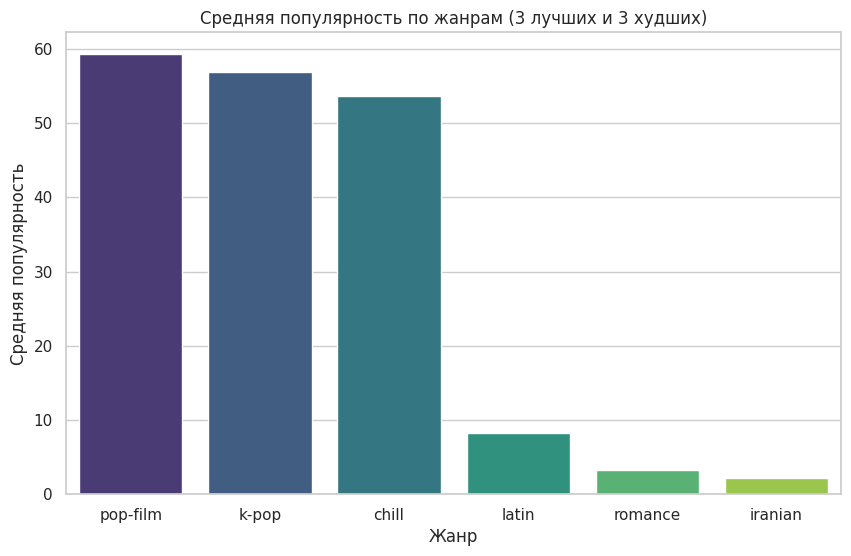

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(data=selected_genres, x='track_genre', y='popularity', palette='viridis')

plt.title('Средняя популярность по жанрам (3 лучших и 3 худших)')
plt.xlabel('Жанр')
plt.ylabel('Средняя популярность')
# plt.xticks(rotation=45)  # Поворот меток на оси X для удобства
plt.show()

Видно, что:

* наибольшая средняя популярность у таких жанров: *pop-film*, *k-pop* и *chill*
* Худшая средняя популярность у таких жанров: *latin*, *romance* и *iranian*

Из этого можно сделать вывод, что жанр сильно влияет на популярность

## Влияние настроения трека на популярность

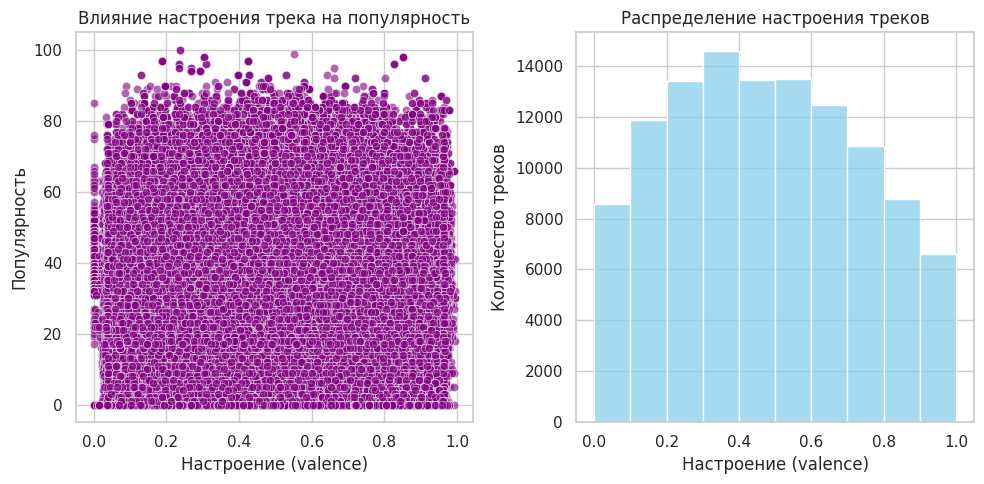

In [43]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='valence', y='popularity', data=data_initial, color='purple', alpha=0.6)
plt.title('Влияние настроения трека на популярность')
plt.xlabel('Настроение (valence)')
plt.ylabel('Популярность')

plt.subplot(1, 2, 2)
sns.histplot(data=data_initial['valence'], bins=np.arange(0, 1.1, 0.1), color='skyblue')
plt.title('Распределение настроения треков')
plt.xlabel('Настроение (valence)')
plt.ylabel('Количество треков')

plt.tight_layout()
plt.show()

* Можно сделать вывод, что настроение трека не влияет на его популярность, так как при любом настроении его популярность кардинально не меняется.
* Треков с грустным звучанием немного больше, чем треков с позитивным звучанием

## Влияние танцевальности и энергичности на популярность

In [44]:
bins = np.arange(0, 1.1, 0.1)

data_initial['dance_bin'] = pd.cut(data_initial['danceability'], bins=bins)
data_initial['energy_bin'] = pd.cut(data_initial['energy'], bins=bins)

heatmap_data = data_initial.groupby(['dance_bin', 'energy_bin']).popularity.mean().reset_index()

heatmap_pivot = heatmap_data.pivot(index='dance_bin', columns='energy_bin', values='popularity')

<ipython-input-44-df3b0e7bfbbf>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data_initial.groupby(['dance_bin', 'energy_bin']).popularity.mean().reset_index()


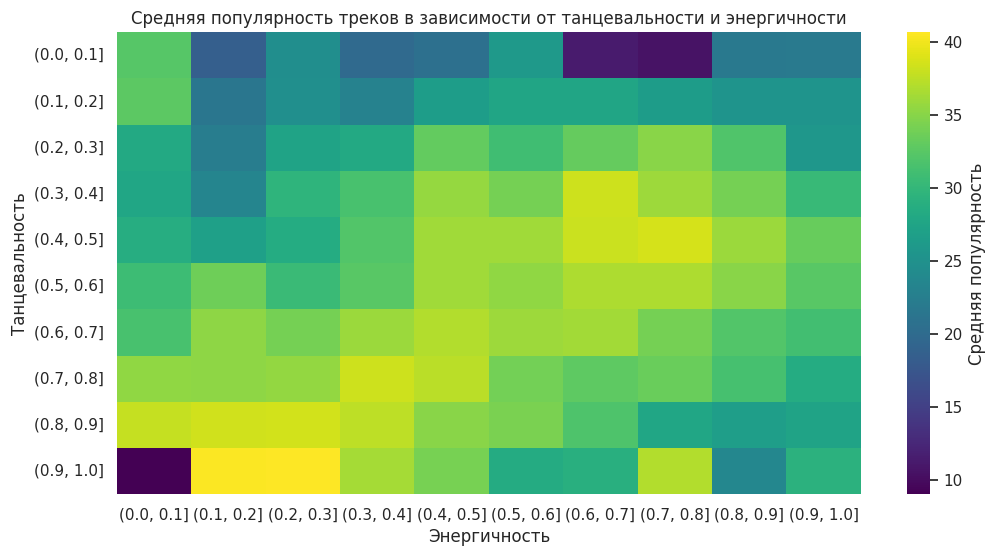

In [45]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot,
    cmap='viridis',
    cbar=True,
    cbar_kws={'label': 'Средняя популярность'}
)

plt.title('Средняя популярность треков в зависимости от танцевальности и энергичности')
plt.xlabel('Энергичность')
plt.ylabel('Танцевальность')
plt.show()

Видно, что наибольшая средняя популярность достигается при энергичности трека в диапазоне (0.1, 0.3] и танцевальности трека в диапазоне (0.9, 1.0]

Можно сказать, что данная комбинация признаков влияет на популярность

# Разбиение датасета на тренировочный и тестовый наборы

In [46]:
# Разделение данных на обучающую и тестовую выборки
# X = data.drop(columns=['popularity', 'track_id', 'valence', 'time_signature', 'Unnamed: 0'])  # измените на ваш целевой признак, если необходимо
X = data.drop(columns=['popularity', 'track_id', 'valence', 'time_signature',
                       'Unnamed: 0', 'explicit', 'key', 'mode', 'liveness'])
y = data['popularity']  # измените на ваш целевой признак, если необходимо
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  int64  
 1   album_name        113999 non-null  int64  
 2   track_name        113999 non-null  int64  
 3   duration_ms       113999 non-null  int64  
 4   danceability      113999 non-null  float64
 5   energy            113999 non-null  float64
 6   loudness          113999 non-null  float64
 7   speechiness       113999 non-null  float64
 8   acousticness      113999 non-null  float64
 9   instrumentalness  113999 non-null  float64
 10  tempo             113999 non-null  float64
 11  track_genre       113999 non-null  int64  
dtypes: float64(7), int64(5)
memory usage: 11.3 MB


# Обучение

In [48]:
import tensorflow as tf
from tensorflow import keras

In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Модель 1

In [ ]:
# Build the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                     │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 649.7713 - val_loss: 485.2553
Epoch 2/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 477.2015 - val_loss: 475.9794
Epoch 3/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 458.7014 - val_loss: 461.7351
Epoch 4/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 449.9792 - val_loss: 455.8712
Epoch 5/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 445.7444 - val_loss: 447.2577
Epoch 6/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 442.8184 - val_loss: 444.4368
Epoch 7/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 436.0560 - val_loss: 443.5294
Epoch 8/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 432.2374 - val_loss: 441.0491
Epoch 9/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 432.1957 - val_loss: 437.1786
Epoch 10/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 424.2634 - val_loss: 435.7463
Epoch 11/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 419.7

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 387.4242
Test Loss: 384.9869384765625


### Результаты обучения

In [ ]:
y_test.value_counts()

,count
popularity,
0,3228
21,482
22,459
44,455
1,450
...,...
97,2
96,1
93,1


In [ ]:
y_test.shape

(22800,)

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 15.60
MSE: 384.99
RMSE: 19.62
R2: 0.22
MAPE: 16652390584541098.00%


1. **MAE (Mean Absolute Error) — Средняя абсолютная ошибка**
  * Это среднее значение абсолютных разностей между предсказанными и фактическими значениями. MAE показывает, насколько в среднем предсказания модели отличаются от реальных значений.
  * Чем меньше значение MAE, тем лучше модель. Если MAE = 0, то модель предсказывает точно.
2. **MSE (Mean Squared Error) — Среднеквадратичная ошибка**
  * Это среднее значение квадратов разностей между предсказанными и фактическими значениями. MSE усиливает влияние больших ошибок, поскольку они возводятся в квадрат.
  * Меньшее значение MSE указывает на лучшую модель. MSE = 0 означает, что модель идеально предсказывает данные. Эта метрика часто используется в задачах оптимизации модели.
3. **RMSE (Root Mean Squared Error) — Корень среднеквадратичной ошибки**
  * Это квадратный корень из MSE, который возвращает ошибку обратно в единицы измерения исходных данных.
  * RMSE помогает понять средний уровень ошибки в тех же единицах, что и исходные данные. Чем меньше RMSE, тем лучше модель. Оптимально, если RMSE близко к 0.
4. **R² (Коэффициент детерминации)**
  * Эта метрика показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значения R² варьируются от 0 до 1:
    * R² = 1: Модель идеально объясняет все изменения зависимой переменной.
    * R² = 0: Модель не объясняет вообще никакой дисперсии зависимой переменной, предсказывает только среднее значение.
    * R² < 0: Это возможно, если модель даёт худшие предсказания, чем простая модель с постоянным средним значением.
5. **MAPE (Mean Absolute Percentage Error) — Средняя абсолютная процентная ошибка**
  * Она измеряет среднюю процентную ошибку предсказаний модели относительно фактических значений.
  * Чем меньше значение MAPE, тем точнее модель. Значение MAPE = 0% означает идеальную точность. Однако, в случае высоких значений или при работе с нулями в данных, MAPE может быть неустойчивым и вызывать аномальные результаты (как в вашем случае).



Использование MAPE бесполезно, так как значительное количество значений в y_test - это 0. Поэтому значение MAPE аномально высокое

MSE = квадрат
MAE = модуль
RMSE = MSE с корнем

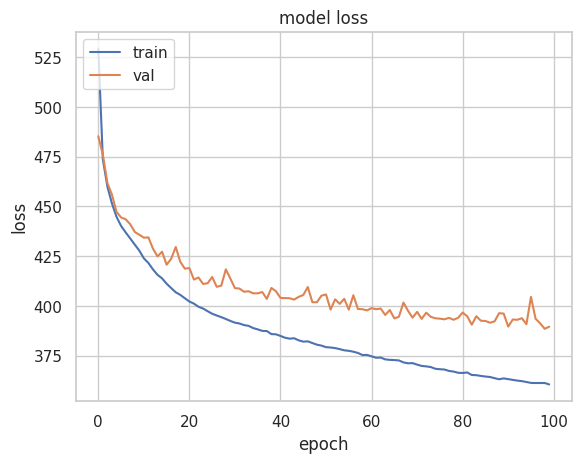

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

На графике видно, что модель начинает переобучаться, так как train_loss уменьшается стремительнее, чем val_loss

Посчитаем важность признаков с помощью permutation importance и визуализируем

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━

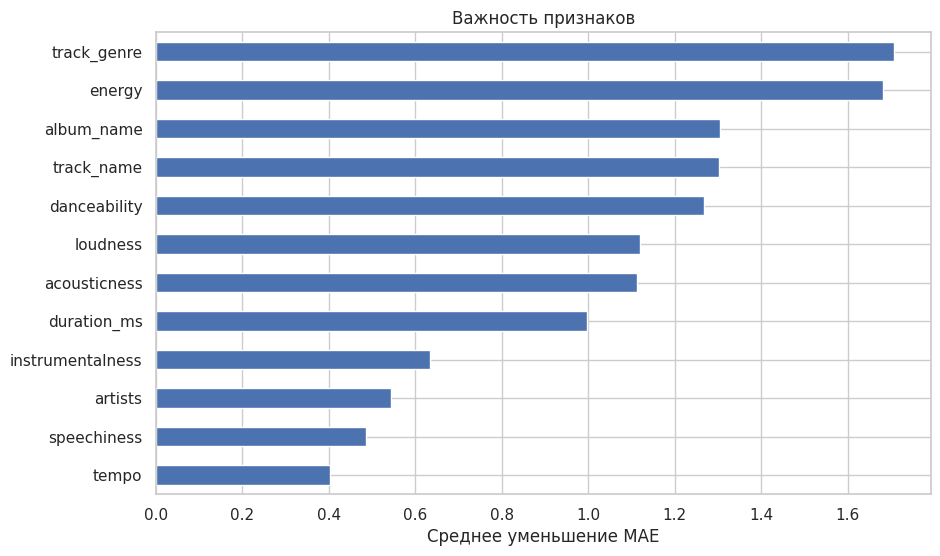

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

## Модель 2

In [ ]:
# Build the model
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,681 (233.13 KB)

 Trainable params: 59,681 (233.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 545.0496 - val_loss: 461.5636
Epoch 2/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 448.6165 - val_loss: 438.2670
Epoch 3/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 430.7573 - val_loss: 433.2332
Epoch 4/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 419.2849 - val_loss: 421.9339
Epoch 5/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 411.6729 - val_loss: 414.1794
Epoch 6/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 402.1719 - val_loss: 414.7639
Epoch 7/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 396.6341 - val_loss: 412.0457
Epoch 8/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 388.9261 - val_loss: 407.4141
Epoch 9/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 381.7587 - val_loss: 398.1698
Epoch 10/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 375.9672 - val_loss: 398.8574
Epoch 11/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 366.

In [ ]:
# Evaluate the model
loss = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 449.4935
Test Loss: 450.52459716796875


### Результаты обучения

In [ ]:
y_test.value_counts()

,count
popularity,
0,3228
21,482
22,459
44,455
1,450
...,...
97,2
96,1
93,1


In [ ]:
y_test.shape

(22800,)

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model2.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 15.45
MSE: 450.52
RMSE: 21.23
R2: 0.09
MAPE: 11230704189753010.00%


1. **MAE (Mean Absolute Error) — Средняя абсолютная ошибка**
  * Это среднее значение абсолютных разностей между предсказанными и фактическими значениями. MAE показывает, насколько в среднем предсказания модели отличаются от реальных значений.
  * Чем меньше значение MAE, тем лучше модель. Если MAE = 0, то модель предсказывает точно.
2. **MSE (Mean Squared Error) — Среднеквадратичная ошибка**
  * Это среднее значение квадратов разностей между предсказанными и фактическими значениями. MSE усиливает влияние больших ошибок, поскольку они возводятся в квадрат.
  * Меньшее значение MSE указывает на лучшую модель. MSE = 0 означает, что модель идеально предсказывает данные. Эта метрика часто используется в задачах оптимизации модели.
3. **RMSE (Root Mean Squared Error) — Корень среднеквадратичной ошибки**
  * Это квадратный корень из MSE, который возвращает ошибку обратно в единицы измерения исходных данных.
  * RMSE помогает понять средний уровень ошибки в тех же единицах, что и исходные данные. Чем меньше RMSE, тем лучше модель. Оптимально, если RMSE близко к 0.
4. **R² (Коэффициент детерминации)**
  * Эта метрика показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значения R² варьируются от 0 до 1:
    * R² = 1: Модель идеально объясняет все изменения зависимой переменной.
    * R² = 0: Модель не объясняет вообще никакой дисперсии зависимой переменной, предсказывает только среднее значение.
    * R² < 0: Это возможно, если модель даёт худшие предсказания, чем простая модель с постоянным средним значением.
5. **MAPE (Mean Absolute Percentage Error) — Средняя абсолютная процентная ошибка**
  * Она измеряет среднюю процентную ошибку предсказаний модели относительно фактических значений.
  * Чем меньше значение MAPE, тем точнее модель. Значение MAPE = 0% означает идеальную точность. Однако, в случае высоких значений или при работе с нулями в данных, MAPE может быть неустойчивым и вызывать аномальные результаты (как в вашем случае).



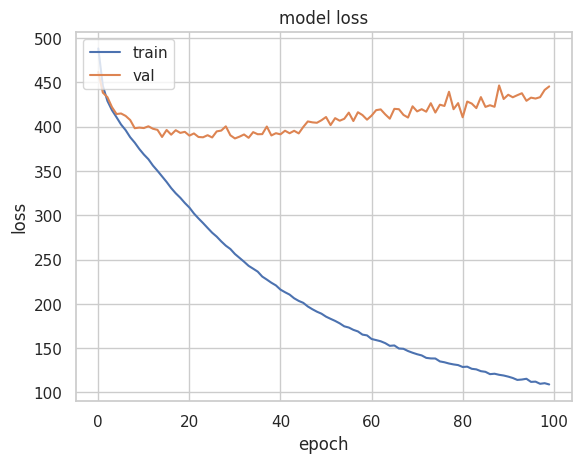

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

На графике видно, что модель переобучилась

Посчитаем важность признаков с помощью permutation importance и визуализируем

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━

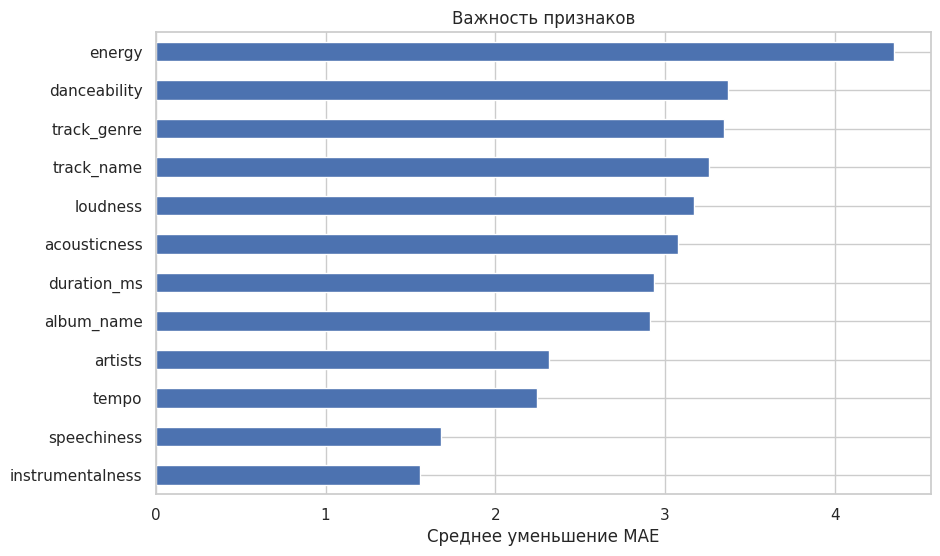

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model2, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

## Модель 3

In [ ]:
# Build the model
model3 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model3.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                     │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,681 (233.13 KB)

 Trainable params: 59,681 (233.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history3 = model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 660.0636 - val_loss: 506.3278
Epoch 2/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 544.8942 - val_loss: 470.1122
Epoch 3/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 527.4464 - val_loss: 468.6382
Epoch 4/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 511.9914 - val_loss: 451.5001
Epoch 5/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 498.7810 - val_loss: 432.5670
Epoch 6/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 495.2380 - val_loss: 455.3152
Epoch 7/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 487.1545 - val_loss: 440.6395
Epoch 8/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 480.3675 - val_loss: 430.8901
Epoch 9/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 474.1472 - val_loss: 428.3755
Epoch 10/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 475.5751 - val_loss: 433.6229
Epoch 11/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 469

In [ ]:
# Evaluate the model
loss = model3.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 403.0312
Test Loss: 398.33636474609375


### Результаты обучения

In [ ]:
y_test.value_counts()

,count
popularity,
0,3228
21,482
22,459
44,455
1,450
...,...
97,2
96,1
93,1


In [ ]:
y_test.shape

(22800,)

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model3.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 16.29
MSE: 398.34
RMSE: 19.96
R2: 0.20
MAPE: 17653346001582772.00%


1. **MAE (Mean Absolute Error) — Средняя абсолютная ошибка**
  * Это среднее значение абсолютных разностей между предсказанными и фактическими значениями. MAE показывает, насколько в среднем предсказания модели отличаются от реальных значений.
  * Чем меньше значение MAE, тем лучше модель. Если MAE = 0, то модель предсказывает точно.
2. **MSE (Mean Squared Error) — Среднеквадратичная ошибка**
  * Это среднее значение квадратов разностей между предсказанными и фактическими значениями. MSE усиливает влияние больших ошибок, поскольку они возводятся в квадрат.
  * Меньшее значение MSE указывает на лучшую модель. MSE = 0 означает, что модель идеально предсказывает данные. Эта метрика часто используется в задачах оптимизации модели.
3. **RMSE (Root Mean Squared Error) — Корень среднеквадратичной ошибки**
  * Это квадратный корень из MSE, который возвращает ошибку обратно в единицы измерения исходных данных.
  * RMSE помогает понять средний уровень ошибки в тех же единицах, что и исходные данные. Чем меньше RMSE, тем лучше модель. Оптимально, если RMSE близко к 0.
4. **R² (Коэффициент детерминации)**
  * Эта метрика показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значения R² варьируются от 0 до 1:
    * R² = 1: Модель идеально объясняет все изменения зависимой переменной.
    * R² = 0: Модель не объясняет вообще никакой дисперсии зависимой переменной, предсказывает только среднее значение.
    * R² < 0: Это возможно, если модель даёт худшие предсказания, чем простая модель с постоянным средним значением.
5. **MAPE (Mean Absolute Percentage Error) — Средняя абсолютная процентная ошибка**
  * Она измеряет среднюю процентную ошибку предсказаний модели относительно фактических значений.
  * Чем меньше значение MAPE, тем точнее модель. Значение MAPE = 0% означает идеальную точность. Однако, в случае высоких значений или при работе с нулями в данных, MAPE может быть неустойчивым и вызывать аномальные результаты (как в вашем случае).



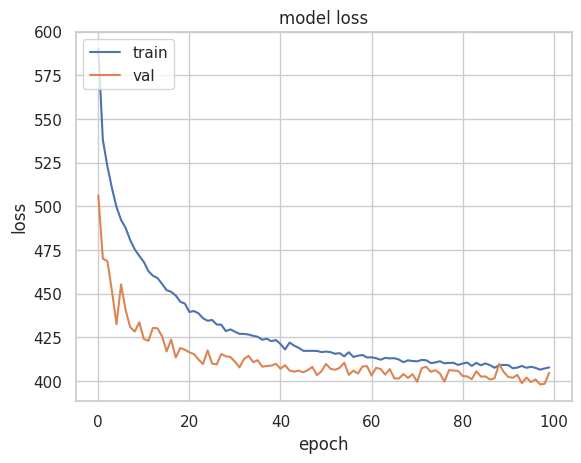

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Посчитаем важность признаков с помощью permutation importance и визуализируем

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model3, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━

## Модель 4

In [50]:
# Build the model
model4 = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Compile the model
model4.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
# Train the model
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 651.9805 - val_loss: 479.3837
Epoch 2/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 513.5438 - val_loss: 473.4326
Epoch 3/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 504.6036 - val_loss: 467.3936
Epoch 4/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 498.1476 - val_loss: 465.7210
Epoch 5/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 489.5771 - val_loss: 460.6548
Epoch 6/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 489.9322 - val_loss: 458.2589
Epoch 7/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 481.6788 - val_loss: 453.4847
Epoch 8/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 475.5374 - val_loss: 450.1895
Epoch 9/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 472.1461 - val_loss: 438.0667
Epoch 10/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 466.9818 - val_loss: 437.8653
Epoch 11/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 457.

In [54]:
# Evaluate the model
loss = model4.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 385.2844
Test Loss: 379.8507080078125


### Результаты обучения

In [55]:
y_test.value_counts()

,count
popularity,
0,3228
21,482
22,459
44,455
1,450
...,...
95,2
91,1
93,1


In [56]:
y_test.shape

(22800,)

In [57]:
# Прогнозирование на тестовой выборке
y_pred = model4.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 15.58
MSE: 379.85
RMSE: 19.49
R2: 0.23
MAPE: 16246415263799958.00%


1. **MAE (Mean Absolute Error) — Средняя абсолютная ошибка**
  * Это среднее значение абсолютных разностей между предсказанными и фактическими значениями. MAE показывает, насколько в среднем предсказания модели отличаются от реальных значений.
  * Чем меньше значение MAE, тем лучше модель. Если MAE = 0, то модель предсказывает точно.
2. **MSE (Mean Squared Error) — Среднеквадратичная ошибка**
  * Это среднее значение квадратов разностей между предсказанными и фактическими значениями. MSE усиливает влияние больших ошибок, поскольку они возводятся в квадрат.
  * Меньшее значение MSE указывает на лучшую модель. MSE = 0 означает, что модель идеально предсказывает данные. Эта метрика часто используется в задачах оптимизации модели.
3. **RMSE (Root Mean Squared Error) — Корень среднеквадратичной ошибки**
  * Это квадратный корень из MSE, который возвращает ошибку обратно в единицы измерения исходных данных.
  * RMSE помогает понять средний уровень ошибки в тех же единицах, что и исходные данные. Чем меньше RMSE, тем лучше модель. Оптимально, если RMSE близко к 0.
4. **R² (Коэффициент детерминации)**
  * Эта метрика показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значения R² варьируются от 0 до 1:
    * R² = 1: Модель идеально объясняет все изменения зависимой переменной.
    * R² = 0: Модель не объясняет вообще никакой дисперсии зависимой переменной, предсказывает только среднее значение.
    * R² < 0: Это возможно, если модель даёт худшие предсказания, чем простая модель с постоянным средним значением.
5. **MAPE (Mean Absolute Percentage Error) — Средняя абсолютная процентная ошибка**
  * Она измеряет среднюю процентную ошибку предсказаний модели относительно фактических значений.
  * Чем меньше значение MAPE, тем точнее модель. Значение MAPE = 0% означает идеальную точность. Однако, в случае высоких значений или при работе с нулями в данных, MAPE может быть неустойчивым и вызывать аномальные результаты (как в вашем случае).



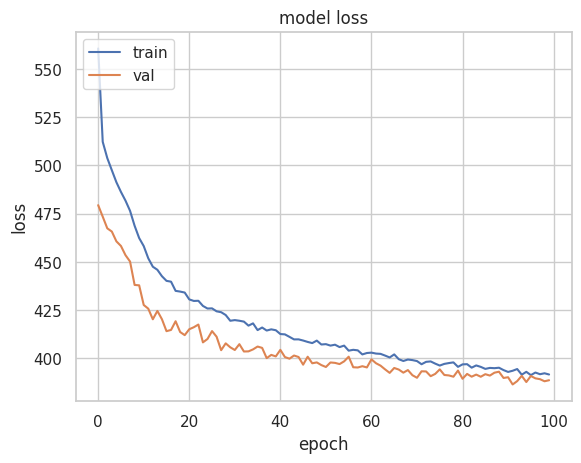

In [58]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Посчитаем важность признаков с помощью permutation importance и визуализируем

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
713/713 ━━━━━━━━

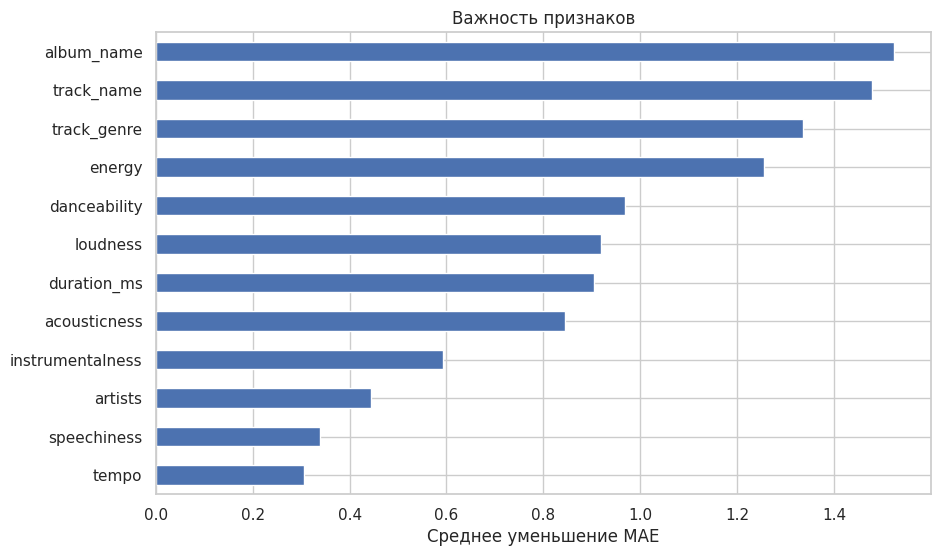

In [59]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model4, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

# Визуализация важности признаков
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()